# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from skimage.io import imread
from skimage.transform import resize as imresize
import datetime
import os
from skimage.io import imshow, imshow_collection
import abc

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [3]:
print(os.getcwd())

/home


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 128#experiment with the batch size

<AxesSubplot:xlabel='Class', ylabel='count'>

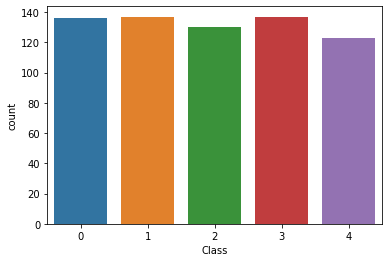

In [5]:
import pandas as pd
import seaborn as sns
label_data = []
for i in range(len(train_doc)):
    label_data.append(int(train_doc[i].split(';')[2]))
label_df = pd.DataFrame({'Class':label_data})
sns.countplot(x='Class', data=label_df)

In [6]:
image_height = 120
image_width = 120
num_images_per_video = 30

/datasets/Project_data/train
/datasets/Project_data/train/WIN_20180926_16_54_08_Pro_Right_Swipe_new
30


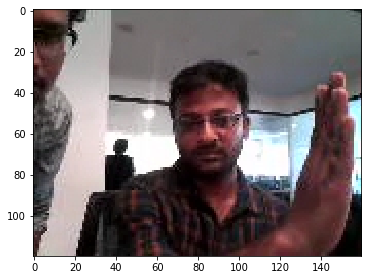

In [7]:
os.chdir('/home/datasets/Project_data/train/')
cwd = os.getcwd()
print(os.getcwd())
folder = train_doc[0].split(';')[0]
images = os.listdir(folder)
os.chdir(cwd+'/'+folder)
print(os.getcwd())
print(len(images))
imshow(images[0])

In [8]:
image = imread(images[0]).astype(np.float32)
print(image[:,:,0])

[[ 94.  97. 103. ...  21.  20.  18.]
 [ 98. 100. 104. ...  72.  53.  41.]
 [ 94.  96. 100. ...  94.  89.  84.]
 ...
 [ 52.  62. 133. ...   5.  10.  13.]
 [ 42.  49. 176. ...   3.   9.  10.]
 [ 69.  49. 194. ...   3.  10.  10.]]


In [9]:
os.chdir('/home')
print(os.getcwd())

/home


In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [11]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [12]:
class ModelBuilder(metaclass= abc.ABCMeta):
    
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.images_per_video=30
    
    def initialize_hyperparams(self,ipv_considered_for_training=30,batch_size=20,num_epochs=20):
        self.ipv_considered_for_training=ipv_considered_for_training
        self.batch_size=batch_size
        self.num_epochs=num_epochs
    
    def initialize_path(self,project_folder='/home/datasets/Project_data'):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
            
    def generator(self,source_path, folder_list, batch_size):
        print( 'Source path = ', source_path, '; batch size =', batch_size)
        img_idx = np.arange(self.ipv_considered_for_training)#create a list of image numbers you want to use for a particular video
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size# calculate the number of batches
            for batch in range(num_batches): # we iterate over the number of batches
                batch_data = np.zeros((batch_size,self.ipv_considered_for_training,self.image_height,self.image_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
                for folder in range(batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                        image = imresize(image, (self.image_height, self.image_width, 3))
                        #crop the images and resize them. Note that the images are of 2 different shape 
                        #and the conv3D will throw error if the inputs in a batch have different shapes
                        batch_data[folder,idx,:,:,0] = (image[:,:,0])/255#normalise and feed in the image
                        batch_data[folder,idx,:,:,1] = (image[:,:,1])/255#normalise and feed in the image
                        batch_data[folder,idx,:,:,2] = (image[:,:,2])/255#normalise and feed in the image
                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        # write the code for the remaining data points which are left after full batches
            left_out_num_batches = len(t)%batch_size
            if left_out_num_batches != 0:
                for batch in range(num_batches, num_batches+1): # we iterate over the number of batches
                    left_out_batch_data = np.zeros((left_out_num_batches,self.ipv_considered_for_training,self.image_height,self.image_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                    left_out_batch_labels = np.zeros((left_out_num_batches,5)) # batch_labels is the one hot representation of the output
                    for folder in range(left_out_num_batches):
                        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                            image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                            image = imresize(image, (self.image_height, self.image_width, 3))
                            #crop the images and resize them. Note that the images are of 2 different shape 
                            #and the conv3D will throw error if the inputs in a batch have different shapes
                            left_out_batch_data[folder,idx,:,:,0] = (image[:,:,0])/255#normalise and feed in the image
                            left_out_batch_data[folder,idx,:,:,1] = (image[:,:,1])/255#normalise and feed in the image
                            left_out_batch_data[folder,idx,:,:,2] = (image[:,:,2])/255#normalise and feed in the image
                        left_out_batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                yield left_out_batch_data, left_out_batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

    def train_model(self, model):
        train_generator = self.generator(self.train_path, self.train_doc, self.batch_size)
        val_generator = self.generator(self.val_path, self.val_doc, self.batch_size)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

    @abc.abstractmethod
    def define_model(self):
        pass

### Tried building the model with batch size greater than 32 but due to the GPU RAM limitations, OOM error raised up. Hence settled down with batch size 20  but ran with little higher batch size of 24 in the consequent runs.

#### Tried the following combinations

#### Model 1 - 3D CNN with Batch Size - 20, IMG SIZE 120x120, Images per Video - 20, Epochs - 20

#### Model 2 - 2D CNN + RNN(LSTMs) with Batch Size - 20, IMG SIZE 100x100, Images per Video - 20, Epochs - 20

#### Model 3 - Transfer Learning + 2D CNN + RNN(LSTMs)  with Batch Size - 20, IMG SIZE 120x120, Images per Video - 20, Epochs - 20

#### Model 4 - Transfer Learning + 2D CNN + RNN(GRUs) with Batch Size - 16, IMG SIZE 80x80, Images per Video - 20, Epochs - 17

#### Model 5 - 3D CNN with Batch Size - 24, IMG SIZE 160x160, Images per Video - 20, Epochs - 30

#### Model 6 - 2D CNN + RNN(LSTMs) with Batch Size - 24, IMG SIZE 160x160, Images per Video - 20, Epochs - 30

#### Model 7 - Transfer Learning + 2D CNN + RNN(LSTMs) with Batch Size - 24, IMG SIZE 120x120, Images per Video - 20, Epochs - 30

#### Model 8 - Transfer Learning + 2D CNN + RNN(GRUs) with Batch Size - 24, IMG SIZE 120x120, Images per Video - 20, Epochs - 17

## Model1 - 3D CNN with Batch Size - 20, IMG SIZE 120x120, Images per Video - 20, Epochs - 20

In [13]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.ipv_considered_for_training,self.image_height,self.image_width,3)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(5,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [15]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path()
conv_3d1.initialize_image_properties(image_height=120,image_width=120)
conv_3d1.initialize_hyperparams(ipv_considered_for_training=20,batch_size=20,num_epochs=20)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 120, 120, 16)  1312      
                                                                 
 activation_4 (Activation)   (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 20, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 10, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 10, 60, 60, 32)    4128      
                                                                 
 activation_5 (Activation)   (None, 10, 60, 60, 32)   

In [16]:
print("Total Params:", conv_3d1_model.count_params())
history = conv_3d1.train_model(conv_3d1_model)

Total Params: 900805
Source path =  /home/datasets/Project_data/train ; batch size = 20


/tmp/ipykernel_419/153145662.py:86: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/20


2022-08-16 12:41:33.187110: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 1.6285 - categorical_accuracy: 0.4148Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2022-08-1612_41_28.657527/model-00001-1.62848-0.41478-3.87222-0.16000.h5
34/34 [==============================] - 109s 3s/step - loss: 1.6285 - categorical_accuracy: 0.4148 - val_loss: 3.8722 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.0080 - categorical_accuracy: 0.6109
Epoch 00002: saving model to model_init_2022-08-1612_41_28.657527/model-00002-1.00799-0.61086-8.30584-0.21000.h5
34/34 [==============================] - 106s 3s/step - loss: 1.0080 - categorical_accuracy: 0.6109 - val_loss: 8.3058 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.8399 - categorical_accuracy: 0.6802
Epoch 00003: saving model to model_init_2022-08-1612_41_28.657527/mo

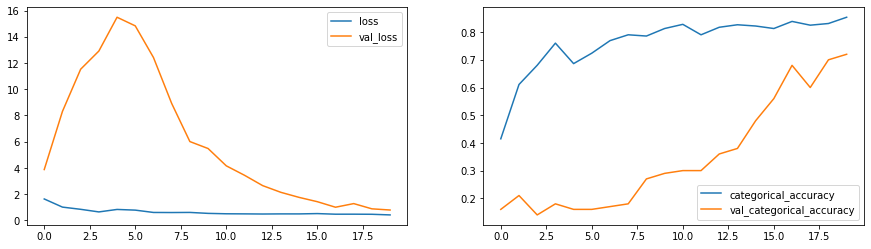

In [17]:
plot(history)

## Model 2 - 2D CNN + RNN with Batch Size - 20, IMG SIZE 100x100, Images per Video - 20, Epochs - 20

In [18]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.ipv_considered_for_training,self.image_height,self.image_width,3)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(5, activation='softmax'))
        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [19]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path()
rnn_cnn1.initialize_image_properties(image_height=100,image_width=100)
rnn_cnn1.initialize_hyperparams(ipv_considered_for_training=20,batch_size=20,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 100, 100, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 100, 100, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 50, 50, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 50, 50, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 50, 50, 32)  

In [20]:
print("Total Params:", rnn_cnn1_model.count_params())
history=rnn_cnn1.train_model(rnn_cnn1_model)

Total Params: 1657445
Source path =  /home/datasets/Project_data/train ; batch size = 20


/tmp/ipykernel_419/153145662.py:86: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4840 - categorical_accuracy: 0.3514Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2022-08-1613_16_56.816411/model-00001-1.48401-0.35143-1.64360-0.24000.h5
34/34 [==============================] - 108s 3s/step - loss: 1.4840 - categorical_accuracy: 0.3514 - val_loss: 1.6436 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.2599 - categorical_accuracy: 0.4585
Epoch 00002: saving model to model_init_2022-08-1613_16_56.816411/model-00002-1.25986-0.45852-2.01715-0.18000.h5
34/34 [==============================] - 103s 3s/step - loss: 1.2599 - categorical_accuracy: 0.4585 - val_loss: 2.0172 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.1226 - categorical_accuracy: 0.5189
Epoch 00003: saving model to model_init_2022-08-1613_16_5

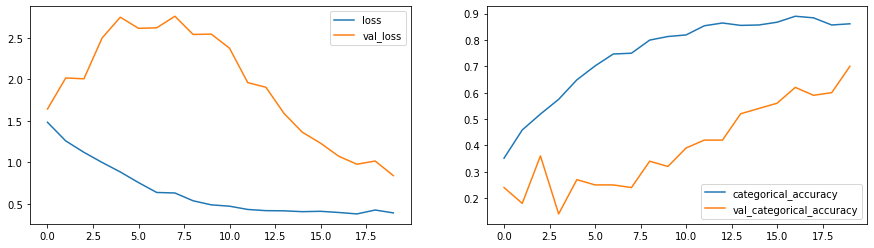

In [21]:
plot(history)

## Model 3 - Transfer Learning + 2D CNN + RNN(LSTMs) with Batch Size - 20, IMG SIZE 120x120, Images per Video - 20, Epochs - 20

In [22]:
from keras.applications import mobilenet

In [23]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.ipv_considered_for_training,self.image_height,self.image_width,3)))
                
        for layer in model.layers:
            layer.trainable = False
            
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(5, activation='softmax'))
        
        
        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [24]:
rnn_cnn_tl=RNNCNN_TL()
rnn_cnn_tl.initialize_path()
rnn_cnn_tl.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl.initialize_hyperparams(ipv_considered_for_training=20,batch_size=20,num_epochs=20)
rnn_cnn_tl_model=rnn_cnn_tl.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 20, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 20, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 20, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 20, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 128)              

In [25]:
print("Total Params:", rnn_cnn_tl_model.count_params())
history=rnn_cnn_tl.train_model(rnn_cnn_tl_model)

Total Params: 3840453
Source path =  /home/datasets/Project_data/train ; batch size = 20


/tmp/ipykernel_419/153145662.py:86: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.5098 - categorical_accuracy: 0.3620Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2022-08-1613_53_22.356255/model-00001-1.50979-0.36199-1.32565-0.50000.h5
34/34 [==============================] - 109s 3s/step - loss: 1.5098 - categorical_accuracy: 0.3620 - val_loss: 1.3256 - val_categorical_accuracy: 0.5000 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.9485 - categorical_accuracy: 0.6833
Epoch 00002: saving model to model_init_2022-08-1613_53_22.356255/model-00002-0.94853-0.68326-0.92791-0.68000.h5
34/34 [==============================] - 106s 3s/step - loss: 0.9485 - categorical_accuracy: 0.6833 - val_loss: 0.9279 - val_categorical_accuracy: 0.6800 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.5443 - categorical_accuracy: 0.8326
Epoch 00003: saving model to model_init_2022-08-1613_53_2

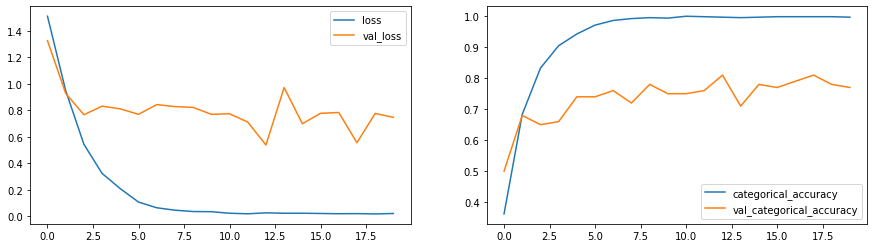

In [26]:
plot(history)

## Model 4 - Transfer Learning + 2D CNN + RNN(GRUs) with Batch Size - 16, IMG SIZE 80x80, Images per Video - 20, Epochs - 17

In [27]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilder):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.ipv_considered_for_training,self.image_height,self.image_width,3)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(5, activation='softmax'))
        
        
        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [28]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path()
rnn_cnn_tl2.initialize_image_properties(image_height=80,image_width=80)
rnn_cnn_tl2.initialize_hyperparams(ipv_considered_for_training=20,batch_size=16,num_epochs=17)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_20 (TimeDi  (None, 20, 2, 2, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_21 (TimeDi  (None, 20, 2, 2, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_22 (TimeDi  (None, 20, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_23 (TimeDi  (None, 20, 1024)         0         
 stributed)                                                      
                                                                 
 gru (GRU)                   (None, 128)              

In [29]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model)

Total Params: 3693253
Source path =  /home/datasets/Project_data/train ; batch size = 16


/tmp/ipykernel_419/153145662.py:86: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/17
42/42 [==============================] - ETA: 0s - loss: 1.2742 - categorical_accuracy: 0.4676Source path =  /home/datasets/Project_data/val ; batch size = 16

Epoch 00001: saving model to model_init_2022-08-1614_42_40.970795/model-00001-1.27420-0.46757-1.26151-0.45000.h5
42/42 [==============================] - 113s 3s/step - loss: 1.2742 - categorical_accuracy: 0.4676 - val_loss: 1.2615 - val_categorical_accuracy: 0.4500 - lr: 0.0010
Epoch 2/17
42/42 [==============================] - ETA: 0s - loss: 0.6310 - categorical_accuracy: 0.7602
Epoch 00002: saving model to model_init_2022-08-1614_42_40.970795/model-00002-0.63099-0.76018-0.65076-0.74000.h5
42/42 [==============================] - 107s 3s/step - loss: 0.6310 - categorical_accuracy: 0.7602 - val_loss: 0.6508 - val_categorical_accuracy: 0.7400 - lr: 0.0010
Epoch 3/17
42/42 [==============================] - ETA: 0s - loss: 0.3198 - categorical_accuracy: 0.8688
Epoch 00003: saving model to model_init_2022-08-1614_42_4

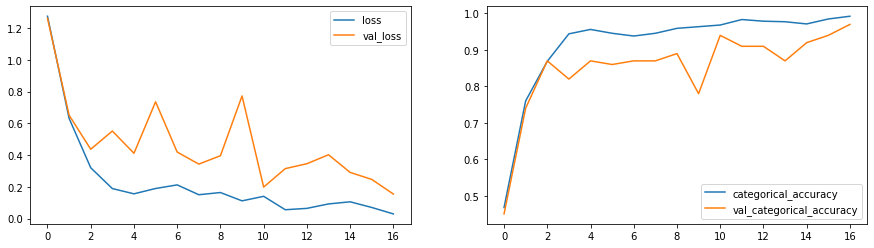

In [30]:
plot(history)

## Model 5 - 3D CNN with Batch Size - 24, IMG SIZE 160x160, Images per Video - 20, Epochs - 30

In [15]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path()
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(ipv_considered_for_training=20,batch_size=24,num_epochs=30)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 20, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 80, 80, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 80, 80, 32)    4128      
                                                                 
 activation_1 (Activation)   (None, 10, 80, 80, 32)    0

2022-08-17 03:10:34.396201: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-08-17 03:10:34.396269: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:40:00.0, compute capability: 7.5


In [16]:
print("Total Params:", conv_3d1_model.count_params())
history = conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Source path =  /home/datasets/Project_data/train ; batch size = 24


/tmp/ipykernel_450/153145662.py:86: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/30


2022-08-17 03:10:51.023836: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


28/28 [==============================] - ETA: 0s - loss: 1.5856 - categorical_accuracy: 0.4359Source path =  /home/datasets/Project_data/val ; batch size = 24

Epoch 00001: saving model to model_init_2022-08-1703_10_44.474442/model-00001-1.58562-0.43590-4.69886-0.16000.h5
28/28 [==============================] - 128s 5s/step - loss: 1.5856 - categorical_accuracy: 0.4359 - val_loss: 4.6989 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/30
28/28 [==============================] - ETA: 0s - loss: 1.0007 - categorical_accuracy: 0.6154
Epoch 00002: saving model to model_init_2022-08-1703_10_44.474442/model-00002-1.00066-0.61538-8.78740-0.17000.h5
28/28 [==============================] - 131s 5s/step - loss: 1.0007 - categorical_accuracy: 0.6154 - val_loss: 8.7874 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/30
28/28 [==============================] - ETA: 0s - loss: 0.7237 - categorical_accuracy: 0.7285
Epoch 00003: saving model to model_init_2022-08-1703_10_44.474442/mo

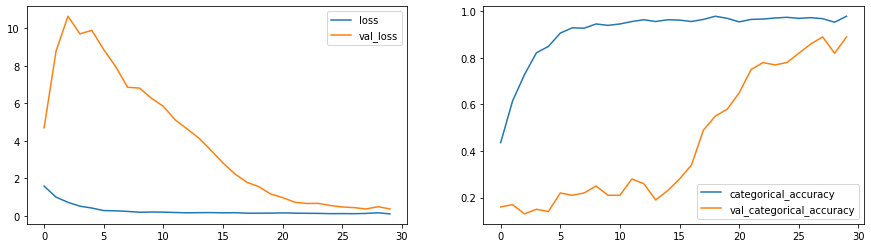

In [17]:
plot(history)

## Model 6 - 2D CNN + RNN(LSTMs) with Batch Size - 24, IMG SIZE 160x160, Images per Video - 20, Epochs - 30

In [19]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path()
rnn_cnn1.initialize_image_properties(image_height=160,image_width=160)
rnn_cnn1.initialize_hyperparams(ipv_considered_for_training=20,batch_size=24,num_epochs=30)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 160, 160, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 160, 160, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 80, 80, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 80, 80, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 80, 80, 32)  

In [20]:
print("Total Params:", rnn_cnn1_model.count_params())
history=rnn_cnn1.train_model(rnn_cnn1_model)

Total Params: 3754597
Source path =  /home/datasets/Project_data/train ; batch size = 24


/tmp/ipykernel_450/153145662.py:86: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/30
28/28 [==============================] - ETA: 0s - loss: 1.5163 - categorical_accuracy: 0.3137Source path =  /home/datasets/Project_data/val ; batch size = 24

Epoch 00001: saving model to model_init_2022-08-1704_11_58.925465/model-00001-1.51634-0.31373-1.61174-0.25000.h5
28/28 [==============================] - 124s 4s/step - loss: 1.5163 - categorical_accuracy: 0.3137 - val_loss: 1.6117 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/30
28/28 [==============================] - ETA: 0s - loss: 1.1630 - categorical_accuracy: 0.5400
Epoch 00002: saving model to model_init_2022-08-1704_11_58.925465/model-00002-1.16302-0.53997-1.61914-0.27000.h5
28/28 [==============================] - 119s 4s/step - loss: 1.1630 - categorical_accuracy: 0.5400 - val_loss: 1.6191 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 3/30
28/28 [==============================] - ETA: 0s - loss: 1.0034 - categorical_accuracy: 0.5852
Epoch 00003: saving model to model_init_2022-08-1704_11_5

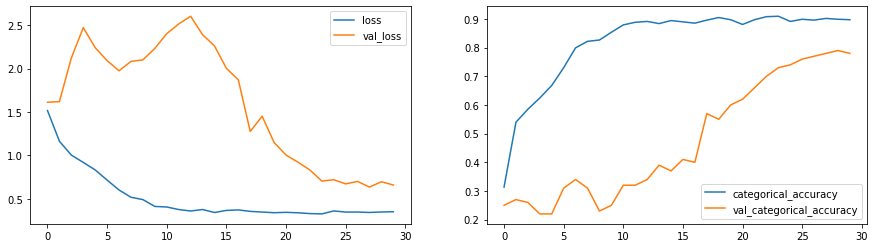

In [21]:
plot(history)

## Model 7 - Transfer Learning + 2D CNN + RNN(LSTMs) with Batch Size - 24, IMG SIZE 120x120, Images per Video - 20, Epochs - 30

In [24]:
rnn_cnn_tl=RNNCNN_TL()
rnn_cnn_tl.initialize_path()
rnn_cnn_tl.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl.initialize_hyperparams(ipv_considered_for_training=20,batch_size=24,num_epochs=30)
rnn_cnn_tl_model=rnn_cnn_tl.define_model(lstm_cells=128,dense_neurons=128,dropout=0.5)
rnn_cnn_tl_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 20, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 20, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 20, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 20, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 128)              

In [25]:
print("Total Params:", rnn_cnn_tl_model.count_params())
history=rnn_cnn_tl.train_model(rnn_cnn_tl_model)

Total Params: 3840453
Source path =  /home/datasets/Project_data/train ; batch size = 24


/tmp/ipykernel_450/153145662.py:86: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/30
28/28 [==============================] - ETA: 0s - loss: 1.7003 - categorical_accuracy: 0.2443Source path =  /home/datasets/Project_data/val ; batch size = 24

Epoch 00001: saving model to model_init_2022-08-1705_14_26.387429/model-00001-1.70031-0.24434-1.46986-0.41000.h5
28/28 [==============================] - 115s 4s/step - loss: 1.7003 - categorical_accuracy: 0.2443 - val_loss: 1.4699 - val_categorical_accuracy: 0.4100 - lr: 0.0010
Epoch 2/30
28/28 [==============================] - ETA: 0s - loss: 1.4240 - categorical_accuracy: 0.3922
Epoch 00002: saving model to model_init_2022-08-1705_14_26.387429/model-00002-1.42403-0.39216-1.29559-0.52000.h5
28/28 [==============================] - 111s 4s/step - loss: 1.4240 - categorical_accuracy: 0.3922 - val_loss: 1.2956 - val_categorical_accuracy: 0.5200 - lr: 0.0010
Epoch 3/30
28/28 [==============================] - ETA: 0s - loss: 1.1749 - categorical_accuracy: 0.5189
Epoch 00003: saving model to model_init_2022-08-1705_14_2

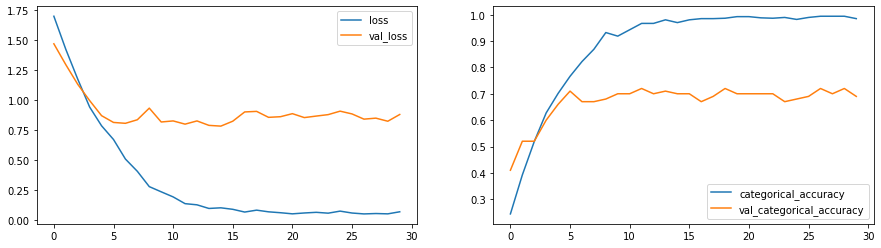

In [26]:
plot(history)

## Model 8 - Transfer Learning + 2D CNN + RNN(GRUs) with Batch Size - 24, IMG SIZE 120x120, Images per Video - 20, Epochs - 17

In [28]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path()
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(ipv_considered_for_training=20,batch_size=24,num_epochs=17)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_20 (TimeDi  (None, 20, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_21 (TimeDi  (None, 20, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_22 (TimeDi  (None, 20, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_23 (TimeDi  (None, 20, 1024)         0         
 stributed)                                                      
                                                                 
 gru (GRU)                   (None, 128)              

In [29]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model)

Total Params: 3693253
Source path =  /home/datasets/Project_data/train ; batch size = 24


/tmp/ipykernel_450/153145662.py:86: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,


Epoch 1/17
28/28 [==============================] - ETA: 0s - loss: 1.1552 - categorical_accuracy: 0.5234Source path =  /home/datasets/Project_data/val ; batch size = 24

Epoch 00001: saving model to model_init_2022-08-1706_10_12.711961/model-00001-1.15524-0.52338-1.11789-0.56000.h5
28/28 [==============================] - 119s 4s/step - loss: 1.1552 - categorical_accuracy: 0.5234 - val_loss: 1.1179 - val_categorical_accuracy: 0.5600 - lr: 0.0010
Epoch 2/17
28/28 [==============================] - ETA: 0s - loss: 0.3770 - categorical_accuracy: 0.8854
Epoch 00002: saving model to model_init_2022-08-1706_10_12.711961/model-00002-0.37697-0.88537-0.55592-0.78000.h5
28/28 [==============================] - 108s 4s/step - loss: 0.3770 - categorical_accuracy: 0.8854 - val_loss: 0.5559 - val_categorical_accuracy: 0.7800 - lr: 0.0010
Epoch 3/17
28/28 [==============================] - ETA: 0s - loss: 0.1811 - categorical_accuracy: 0.9306
Epoch 00003: saving model to model_init_2022-08-1706_10_1

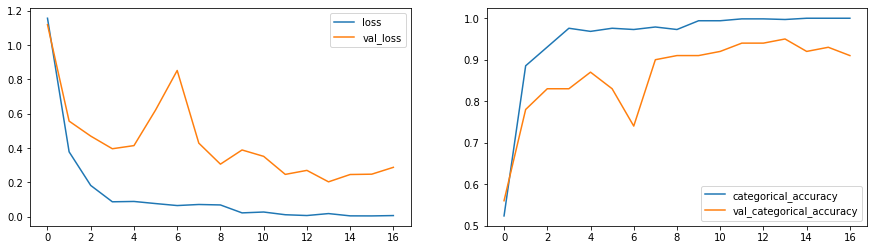

In [30]:
plot(history)